**Google Drive Mount**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Install Library**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Load Dataset**

In [0]:
train = pd.read_excel('/content/drive/My Drive/Tugas_Akhir/dataset/dataset.xlsx', index_col=0)

**Load Model**

In [0]:
y_train = train['label'].tolist()

In [142]:
import os, re, csv, math, codecs
from tqdm import tqdm

print('loading word embeddings...')

embeddings_index = {}

f = codecs.open('/content/drive/My Drive/Tugas_Akhir/model/ft_model.vec', encoding='utf-8')

for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

f.close()

print('Found %s word vectors' %len(embeddings_index))

1716it [00:00, 17151.92it/s]

loading word embeddings...


201428it [00:10, 18644.46it/s]

Found 201428 word vectors


In [143]:
print('num train : ', train.shape[0])
# print('num test  : ', test.shape[0])

num train :  3582


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

label_names = ['positive', 'neutral','negative']

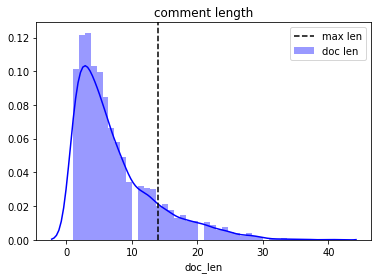

In [145]:
train['doc_len'] = train['text'].apply(lambda words: len(words.split(' ')))

max_seq_len = np.round(train['doc_len'].mean() + train['doc_len'].std()).astype(int)

sns.distplot(train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length')
plt.legend()
plt.show()

In [0]:
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

In [147]:
raw_docs_train = train['text'].tolist()
# raw_docs_test  = test['text'].tolist()

MAX_NB_WORDS = 100000
num_classes = len(label_names)

print('tokenizing input data...')

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,
                      lower=True,
                      char_level=False)
# tokenizer.fit_on_texts(raw_docs_train + raw_docs_test)
tokenizer.fit_on_texts(raw_docs_train)


word_seq_train = tokenizer.texts_to_sequences(raw_docs_train)
# word_seq_test  = tokenizer.texts_to_sequences(raw_docs_test)

word_index = tokenizer.word_index

print('dictionary size: ', len(word_index))

word_seq_train = sequence.pad_sequences(word_seq_train, maxlen = max_seq_len)
# word_seq_test  = sequence.pad_sequences(word_seq_test, maxlen = max_seq_len)


tokenizing input data...
dictionary size:  7495


In [0]:
batch_size = 256
num_epochs = 8

num_filters = 64
embed_dim   = 100
weight_decay = 1e-4

In [149]:
print('preparing embedding matrix...')

words_not_found = []

nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words+1, embed_dim))

for word, i in word_index.items():
  if i >= nb_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if (embedding_vector is not None) and len(embedding_vector) > 0:
    embedding_matrix[i] = embedding_vector
  else:
    words_not_found.append(word)

print('number of null word embeddings: %d' %np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 323


In [150]:
print('sample words not found: ', np.random.choice(words_not_found, 10))

sample words not found:  ['klw' 'rrraayaa' 'yaallah' 'ngaca' 'bhsamu' 'homiped' 'disgusting'
 'tndakan' 'ngadepin' 'mikirnya']


In [160]:
from keras.layers.normalization import BatchNormalization

print('training CNN ... ')

model = Sequential()
model.add(Embedding(nb_words+1, embed_dim,
                    weights=[embedding_matrix],
                    input_length=max_seq_len,
                    trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(BatchNormalization())
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='softmax'))

adam = optimizers.Adam(lr = 0.01,
                      beta_1 = 0.9,
                      beta_2 = 0.999,
                      epsilon=1e-08,
                      decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

training CNN ... 
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 14, 100)           749600    
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 14, 64)            44864     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 7, 64)             0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 7, 64)             256       
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 7, 64)             28736     
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 64)                0         
_________________________________________________________________
batch_normalization_18 (Batc (None,

In [0]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.01,
                               patience=3,
                               verbose=1)

callbacks_list = [early_stopping]

In [0]:
categorical = []

for i in train['label']:
  if i == -1:
    categorical.append(0)
  elif i == 0:
    categorical.append(1)
  elif i == 1:
    categorical.append(2)

train['categorical'] = categorical

In [0]:
# categorical = []

# for i in test['label']:
#   if i == -1:
#     categorical.append(0)
#   elif i == 0:
#     categorical.append(1)
#   elif i == 1:
#     categorical.append(2)

# test['categorical'] = categorical

In [0]:
from keras.utils import to_categorical

train_labels = to_categorical(train['categorical'])

In [0]:
# y_test = to_categorical(test['categorical'])

In [166]:
hist = model.fit(word_seq_train,
                 train_labels,
                 batch_size = batch_size,
                 epochs = num_epochs,
                 validation_split=0.2,
                 callbacks = callbacks_list,
                 shuffle=True,
                 verbose=2)

Train on 2865 samples, validate on 717 samples
Epoch 1/8
 - 1s - loss: 0.9985 - accuracy: 0.5832 - val_loss: 0.8726 - val_accuracy: 0.6234
Epoch 2/8
 - 0s - loss: 0.2944 - accuracy: 0.9072 - val_loss: 0.8113 - val_accuracy: 0.7127
Epoch 3/8
 - 0s - loss: 0.1620 - accuracy: 0.9550 - val_loss: 0.8144 - val_accuracy: 0.7392
Epoch 4/8
 - 0s - loss: 0.1320 - accuracy: 0.9606 - val_loss: 0.8176 - val_accuracy: 0.7462
Epoch 5/8
 - 0s - loss: 0.1010 - accuracy: 0.9686 - val_loss: 0.7964 - val_accuracy: 0.7531
Epoch 6/8
 - 0s - loss: 0.0860 - accuracy: 0.9777 - val_loss: 0.7835 - val_accuracy: 0.7629
Epoch 7/8
 - 0s - loss: 0.0720 - accuracy: 0.9798 - val_loss: 0.7909 - val_accuracy: 0.7671
Epoch 8/8
 - 0s - loss: 0.0622 - accuracy: 0.9850 - val_loss: 0.7895 - val_accuracy: 0.7727


**Visualization**

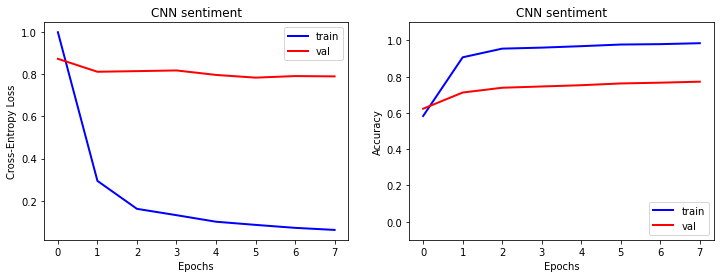

In [167]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(hist.history['loss'], lw=2.0, color='b', label='train')
ax1.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
ax1.set_title('CNN sentiment')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.legend(loc='upper right')
ax2.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
ax2.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
ax2.set_title('CNN sentiment')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

ax2.set_ylim(-0.1, 1.1)
plt.show()